# Simulate Data

## LLDA

In [12]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.linalg import eigh
from scipy.spatial.distance import cdist
from sklearn.neighbors import KNeighborsClassifier

# Generate simulated data (Set 1 in the paper)
def generate_dataset1(n_samples=200):
    # Class 1 (two modes)
    c1_mode1 = np.column_stack([np.random.normal(7, 0.9, n_samples),
                               np.random.normal(4.1, 0.8, n_samples)])
    c1_mode2 = np.column_stack([np.random.normal(-8.4, 0.9, n_samples),
                               np.random.normal(-3, 0.7, n_samples)])
    c1 = np.vstack([c1_mode1, c1_mode2])
    
    # Class 2 (two modes)
    c2_mode1 = np.column_stack([np.random.normal(5, 0.9, n_samples),
                               np.random.normal(0.1, 1, n_samples)])
    c2_mode2 = np.column_stack([np.random.normal(-4, 0.9, n_samples),
                               np.random.normal(0.1, 0.6, n_samples)])
    c2 = np.vstack([c2_mode1, c2_mode2])
    
    # Class 3 (2 modes)
    c3_mode1 = np.column_stack([np.random.normal(2.9, 0.9, n_samples),
                               np.random.normal(2.9, 0.5, n_samples)])
    c3_mode2 = np.column_stack([np.random.normal(-4.2, 0.9, n_samples),
                               np.random.normal(-4.2, 0.4, n_samples)])
    c3 = np.vstack([c3_mode1, c3_mode2])
    
    X = np.vstack([c1, c2, c3])
    y = np.hstack([np.zeros(2*n_samples), np.ones(2*n_samples), 2*np.ones(2*n_samples)])
    return X, y

# 2. LLDA_GMM implementation (using GMM soft clustering)
class LLDA_GMM:
    def __init__(self, n_clusters=2, d_components=1, alpha=0.1, max_iter=100):
        self.n_clusters = n_clusters  # GMM clusters
        self.d_components = d_components  # # Number of components after dimensionality reduction
        self.alpha = alpha  # Alpha parameter of the objective function J2
        self.max_iter = max_iter

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.n_classes = len(self.classes_)

        # Step 1: Soft clustering using GMM
        self.gmm = GaussianMixture(n_components=self.n_clusters,
                                   covariance_type='diag')
        self.gmm.fit(X)
        self.mu_k = self.gmm.means_  # cluster centers

        # Step 2: Calculate posterior probability P(k|x)
        self.P = self.gmm.predict_proba(X)  # (n_samples, n_components)

        # Step 3: Initialize local transformation matrix U_k
        self.U = [np.random.randn(X.shape[1], self.d_components)
                  for _ in range(self.n_clusters)]
        for k in range(self.n_clusters):
            q, _ = np.linalg.qr(self.U[k])
            self.U[k] = q

        # Step 4: Gradient descent to optimize the objective function J2
        learning_rate = 0.01
        for _ in range(self.max_iter):
            # gradient
            grads = [np.zeros_like(u) for u in self.U]

            # intermediate quantities
            B_k = [np.zeros((X.shape[1], X.shape[1]))
                   for _ in range(self.n_clusters)]
            W_k = [np.zeros((X.shape[1], X.shape[1]))
                   for _ in range(self.n_clusters)]
            B_ij = np.zeros((self.n_clusters, self.n_clusters,
                             X.shape[1], X.shape[1]))
            W_ij = np.zeros((self.n_clusters, self.n_clusters,
                             X.shape[1], X.shape[1]))

            # class statstics
            for c in range(self.n_classes):
                X_c = X[y == self.classes_[c]]
                P_c = self.P[y == self.classes_[c]]
                M_c = len(X_c)

                for k in range(self.n_clusters):
                    # Calculate m_ck, add a smoothing term to prevent division by zero
                    sum_p_ck = P_c[:, k].sum() + 1e-8
                    m_ck = (P_c[:, k].reshape(-1, 1) * (X_c - self.mu_k[k])).sum(axis=0) / sum_p_ck
                    B_k[k] += M_c * np.outer(m_ck, m_ck)

                    # W_k
                    diff = P_c[:, k].reshape(-1, 1) * (X_c - self.mu_k[k]) - m_ck
                    W_k[k] += diff.T @ diff

                    # B_ij and W_ij
                    for j in range(k + 1, self.n_clusters):
                        # smooth modify
                        sum_p_cj = P_c[:, j].sum() + 1e-8
                        m_cj = (P_c[:, j].reshape(-1, 1) * (X_c - self.mu_k[j])).sum(axis=0) / sum_p_cj
                        B_ij[k, j] += M_c * np.outer(m_ck, m_cj)

                        diff_i = P_c[:, k].reshape(-1, 1) * (X_c - self.mu_k[k]) - m_ck
                        diff_j = P_c[:, j].reshape(-1, 1) * (X_c - self.mu_k[j]) - m_cj
                        W_ij[k, j] += diff_i.T @ diff_j

            # Calculate Gradient
            for k in range(self.n_clusters):
                grad = 2 * (1 - self.alpha) * B_k[k] @ self.U[k] - 2 * \
                    self.alpha * W_k[k] @ self.U[k]
                for j in range(self.n_clusters):
                    if j != k:
                        grad += 2 * (1 - self.alpha) * \
                            B_ij[min(k, j), max(k, j)] @ self.U[j]
                        grad -= 2 * self.alpha * \
                            W_ij[min(k, j), max(k, j)] @ self.U[j]
                grads[k] = grad

            # Update U and orthogonalize
            for k in range(self.n_clusters):
                self.U[k] += learning_rate * grads[k]
                q, _ = np.linalg.qr(self.U[k])
                self.U[k] = q

        return self

    def transform(self, X):
        # Calculate posterior probability
        P_test = self.gmm.predict_proba(X)

        # Apply local transformation
        y_proj = np.zeros((X.shape[0], self.d_components))
        for k in range(self.n_clusters):
            y_proj += P_test[:, k].reshape(-1, 1) * \
                (X - self.mu_k[k]) @ self.U[k]
        return y_proj

# LLDA_KMeans implementation (using KMeans hard clustering)

class LLDA_KMeans:
    def __init__(self, n_clusters=2, d_components=1, max_iter=100):
        self.n_clusters = n_clusters
        self.d_components = d_components
        self.max_iter = max_iter

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.n_classes = len(self.classes_)
        n_features = X.shape[1]

        # Step 1: KMeans clustering
        self.kmeans = KMeans(n_clusters=self.n_clusters, n_init=10)
        self.kmeans.fit(X)
        self.labels_ = self.kmeans.labels_
        self.mu_k = self.kmeans.cluster_centers_

        # Step 2: Initialize transformation matrix U_k and orthogonalize
        self.U = [np.random.randn(n_features, self.d_components) for _ in range(self.n_clusters)]
        for k in range(self.n_clusters):
            q, _ = np.linalg.qr(self.U[k])
            self.U[k] = q

        # Step 3: Gradient descent optimization
        learning_rate = 0.01
        for _ in range(self.max_iter):
            B_k = [np.zeros((n_features, n_features)) for _ in range(self.n_clusters)]
            B_ij = np.zeros((self.n_clusters, self.n_clusters, n_features, n_features))
            W_k = [np.zeros((n_features, n_features)) for _ in range(self.n_clusters)]
            W_ij = np.zeros((self.n_clusters, self.n_clusters, n_features, n_features))

            for c in range(self.n_classes):
                X_c = X[y == self.classes_[c]]
                M_c = X_c.shape[0]
                labels_c = self.kmeans.predict(X_c)

                for k in range(self.n_clusters):
                    mask = (labels_c == k)
                    if np.sum(mask) == 0:
                        continue  # skip empty
                    m_ck = (X_c[mask] - self.mu_k[k]).mean(axis=0)
                    B_k[k] += M_c * np.outer(m_ck, m_ck)

                    # W_k
                    diff = (X_c[mask] - self.mu_k[k]) - m_ck
                    W_k[k] += diff.T @ diff

                    # B_ij
                    for j in range(self.n_clusters):
                        if j == k:
                            continue
                        mask_j = (labels_c == j)
                        if np.sum(mask_j) == 0:
                            continue
                        m_cj = (X_c[mask_j] - self.mu_k[j]).mean(axis=0)
                        B_ij[k, j] += M_c * np.outer(m_ck, m_cj)

            # Calculate B_tilde and W_tilde 
            B_tilde = np.zeros((self.d_components, self.d_components))
            W_tilde = np.zeros((self.d_components, self.d_components))
            for k in range(self.n_clusters):
                B_tilde += self.U[k].T @ B_k[k] @ self.U[k]
                W_tilde += self.U[k].T @ W_k[k] @ self.U[k]

            # Add regularization terms
            B_tilde_inv = np.linalg.pinv(B_tilde + 1e-6 * np.eye(self.d_components))
            W_tilde_inv = np.linalg.pinv(W_tilde + 1e-6 * np.eye(self.d_components))

            # Gradient update (only calculate the main terms)
            for k in range(self.n_clusters):
                grad = np.zeros((n_features, self.d_components))
                for n in range(self.d_components):
                    u_kn = self.U[k][:, n]
                    term1 = (
                        2 * (self.U[k] @ B_tilde_inv @ (self.U[k].T @ B_k[k])) 
                        - 2 * (self.U[k] @ W_tilde_inv @ (self.U[k].T @ W_k[k]))
                    ) @ u_kn
                    grad[:, n] = term1
                
                self.U[k] += learning_rate * grad
                q, _ = np.linalg.qr(self.U[k])
                self.U[k] = q

        return self

    def transform(self, X):
        labels_test = self.kmeans.predict(X)
        y_proj = np.zeros((X.shape[0], self.d_components))
        for k in range(self.n_clusters):
            mask = (labels_test == k)
            if np.sum(mask) > 0:
                y_proj[mask] = (X[mask] - self.mu_k[k]) @ self.U[k]
        return y_proj
    
class KernelLDA:
    def __init__(self, kernel='rbf', gamma=1e-5, d_components=2):
        self.kernel = kernel
        self.gamma = gamma
        self.d_components = d_components
        self.alpha = None
        self.X_train = None

    def fit(self, X, y):
        self.X_train = X
        n_samples = X.shape[0]
        classes = np.unique(y)
        n_classes = len(classes)
        if self.d_components is None or self.d_components > n_classes - 1:
            self.d_components = n_classes - 1

        # 计算核矩阵
        K = self._compute_kernel(X, X)

        # 初始化散度矩阵
        Sb = np.zeros((n_samples, n_samples))
        Sw = np.zeros((n_samples, n_samples))
        total_mean = np.mean(K, axis=0)

        for c in classes:
            idx = (y == c)
            n_c = np.sum(idx)
            if n_c == 0:
                continue
            class_mean = np.mean(K[idx], axis=0)
            # 类间散度
            mean_diff = (class_mean - total_mean).reshape(-1, 1)
            Sb += n_c * np.dot(mean_diff, mean_diff.T)
            # 类内散度
            K_c = K[idx]
            for vec in K_c:
                diff = (vec - class_mean).reshape(-1, 1)
                Sw += np.dot(diff, diff.T)

        # 正则化Sw
        Sw += 1e-6 * np.eye(Sw.shape[0])
        # 求解广义特征值问题
        eigenvalues, eigenvectors = eigh(Sb, Sw)
        idx = np.argsort(eigenvalues)[::-1]
        self.alpha = eigenvectors[:, idx][:, :self.d_components]

    def _compute_kernel(self, X, Y):
        if self.kernel == 'rbf':
            if self.gamma is None:
                self.gamma = 1.0 / X.shape[1]
            pairwise_dists = cdist(X, Y, 'sqeuclidean')
            return np.exp(-self.gamma * pairwise_dists)
        elif self.kernel == 'linear':
            return np.dot(X, Y.T)
        else:
            raise ValueError("Unsupported kernel")

    def transform(self, X):
        K = self._compute_kernel(X, self.X_train)
        return np.dot(K, self.alpha)


In [13]:

# Simulate Data
# Generate data
X, y = generate_dataset1(n_samples=200)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# train LLDA_GMM
llda_gmm = LLDA_GMM(n_clusters=2, d_components=1)
llda_gmm.fit(X_train, y_train)

# train LLDA_KMeans
llda_kmeans = LLDA_KMeans(n_clusters=2, d_components=1)
llda_kmeans.fit(X_train, y_train)

# train LDA baseline
lda = LDA()
lda.fit(X_train, y_train)

# evaluate 
def evaluate_model(model, X, y):
    if hasattr(model, 'predict'):
        y_pred = model.predict(X)
    else:  # For LLDA using nearest centroid
        centroids = []
        for c in np.unique(y):
            centroids.append(X[y==c].mean(axis=0))
        centroids = np.array(centroids)
        y_pred = np.argmin(np.linalg.norm(X[:, None] - centroids, axis=2), axis=1)
    return accuracy_score(y, y_pred)

print("LLDA_GMM Accuracy:")
print("Train:", evaluate_model(llda_gmm, llda_gmm.transform(X_train), y_train))
print("Test :", evaluate_model(llda_gmm, llda_gmm.transform(X_test), y_test))

print("\nLLDA_KMeans Accuracy:")
print("Train:", evaluate_model(llda_kmeans, llda_kmeans.transform(X_train), y_train))
print("Test :", evaluate_model(llda_kmeans, llda_kmeans.transform(X_test), y_test))

print("\nLDA Accuracy:")
print("Train:", evaluate_model(lda, X_train, y_train))
print("Test :", evaluate_model(lda, X_test, y_test))

d:\Python\Anaconda\Anaconda3\envs\main_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
d:\Python\Anaconda\Anaconda3\envs\main_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


LLDA_GMM Accuracy:
Train: 0.3488095238095238
Test : 0.375

LLDA_KMeans Accuracy:
Train: 0.38095238095238093
Test : 0.36666666666666664

LDA Accuracy:
Train: 0.430952380952381
Test : 0.4222222222222222


# Olivetti data

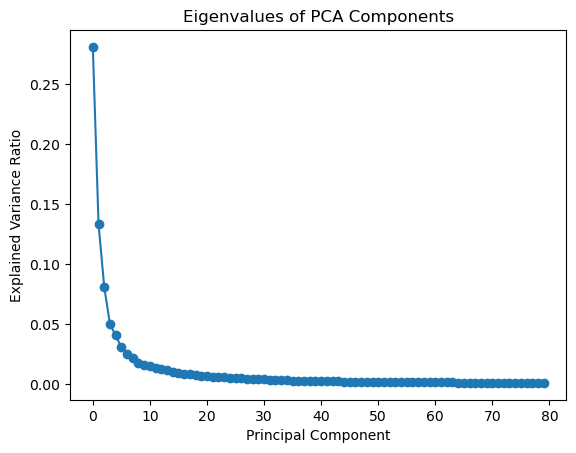

In [14]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score


# loading data
data = fetch_olivetti_faces(shuffle=True, random_state=42)
X, y = data.data, data.target

# Get each person's unique ID
unique_subjects = np.unique(y)

train_subjects, test_subjects = train_test_split(unique_subjects, test_size=0.3, random_state=42)

# Divide the training set and test set according to the person's identity
X_train = []
y_train = []
X_test = []
y_test = []

for subject in train_subjects:
    indices = np.where(y == subject)[0]
    X_train.extend(X[indices])
    y_train.extend(y[indices])

for subject in test_subjects:
    indices = np.where(y == subject)[0]
    X_test.extend(X[indices])
    y_test.extend(y[indices])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reduce dimensionality to 80 eigenfeatures
n_components = 80
pca = PCA(n_components=n_components, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Plot eigenvalues
plt.plot(pca.explained_variance_ratio_, 'o-')
plt.title('Eigenvalues of PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()
    


In [15]:
# Train LLDA_GMM
d = 4

llda_gmm = LLDA_GMM(n_clusters=3, d_components=d, max_iter=100)
llda_gmm.fit(X_train_pca, y_train)

# Train LLDA_KMeans
llda_kmeans = LLDA_KMeans(n_clusters=3, d_components=d, max_iter=100)
llda_kmeans.fit(X_train_pca, y_train)

# Train LDA
lda = LDA(n_components=d)
lda.fit(X_train_pca, y_train)

# Train KernelLDA (GDA)
kernel_lda = KernelLDA(kernel='rbf', gamma=1e-5, d_components=d)
kernel_lda.fit(X_train_pca, y_train)

# Testing

# For the test set, each person picks out a face photo to put into KNN training, and the remaining photos are used as the KNN test set
unique_subjects = np.unique(y_test)
X_knn_train = []
y_knn_train = []
X_knn_test = []
y_knn_test = []

for subject in unique_subjects:
    indices = np.where(y_test == subject)[0]
    # Select a sample as a training set
    train_index = indices[0]
    X_knn_train.append(X_test_pca[train_index])
    y_knn_train.append(y_test[train_index])
    # remaining samples are used as the test set
    test_indices = indices[1:]
    X_knn_test.extend(X_test_pca[test_indices])
    y_knn_test.extend(y_test[test_indices])

X_knn_train = np.array(X_knn_train)
y_knn_train = np.array(y_knn_train)
X_knn_test = np.array(X_knn_test)
y_knn_test = np.array(y_knn_test)


# LLDA_kmeans projection
X_knn_train_LLDA_Kmeans = llda_kmeans.transform(X_knn_train)
X_knn_test_LLDA_Kmeans = llda_kmeans.transform(X_knn_test)

# train KNN
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_knn_train_LLDA_Kmeans, y_knn_train)

# KNN test
y_pred = knn.predict(X_knn_test_LLDA_Kmeans)

# calculate the accuracy
accuracy = np.mean(y_pred == y_knn_test)
print(f"LLDA_Kmeans face recognization accuracy: {accuracy * 100:.2f}%")


# LDA
X_knn_train_LDA = lda.transform(X_knn_train)
X_knn_test_LDA = lda.transform(X_knn_test)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_knn_train_LDA, y_knn_train)
y_pred = knn.predict(X_knn_test_LDA)
accuracy = np.mean(y_pred == y_knn_test)
print(f"LDA face recognization accuracy: {accuracy * 100:.2f}%")


# LLDA_GMM
X_knn_train_LDA = llda_gmm.transform(X_knn_train)
X_knn_test_LDA = llda_gmm.transform(X_knn_test)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_knn_train_LDA, y_knn_train)
y_pred = knn.predict(X_knn_test_LDA)
accuracy = np.mean(y_pred == y_knn_test)
print(f"LLDA_GMM face recognization accuracy: {accuracy * 100:.2f}%")

# KernelLDA
X_knn_train_KernelLDA = kernel_lda.transform(X_knn_train)
X_knn_test_KernelLDA = kernel_lda.transform(X_knn_test)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_knn_train_KernelLDA, y_knn_train)
y_pred = knn.predict(X_knn_test_KernelLDA)
accuracy = np.mean(y_pred == y_knn_test)
print(f"KernelLDA face recognization accuracy: {accuracy * 100:.2f}%")

d:\Python\Anaconda\Anaconda3\envs\main_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Python\Anaconda\Anaconda3\envs\main_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


LLDA_Kmeans face recognization accuracy: 17.59%
LDA face recognization accuracy: 60.19%
LLDA_GMM face recognization accuracy: 24.07%
KernelLDA face recognization accuracy: 60.19%


d:\Python\Anaconda\Anaconda3\envs\main_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Python\Anaconda\Anaconda3\envs\main_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Python\Anaconda\Anaconda3\envs\main_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Python\Anaconda\Anaconda3\envs\main_env\lib\site-packages\sklearn\cluster\_kmea

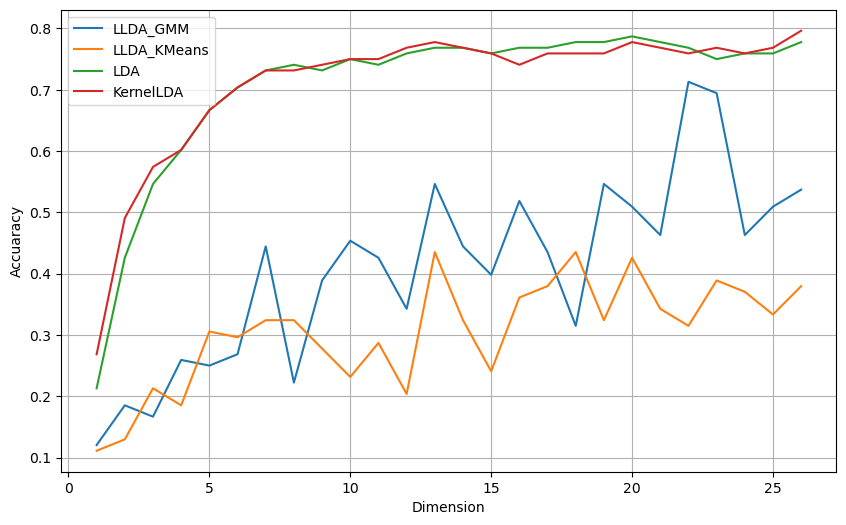

In [16]:
# Just for drawing
# Initialize the result list
llda_gmm_accuracies = []
llda_kmeans_accuracies = []
lda_accuracies = []
kernel_lda_accuracies = []

for d in range(1, 27):

    # # Reduce dimensionality to 80 eigenfeatures
    # n_components = 80
    # pca = PCA(n_components=n_components, whiten=True)
    # X_train_pca = pca.fit_transform(X_train)
    # X_test_pca = pca.transform(X_test)

    # Train LLDA_GMM
    llda_gmm = LLDA_GMM(n_clusters=3, d_components=d, max_iter=100)
    llda_gmm.fit(X_train_pca, y_train)

    # Train LLDA_KMeans
    llda_kmeans = LLDA_KMeans(n_clusters=3, d_components=d, max_iter=100)
    llda_kmeans.fit(X_train_pca, y_train)

    # Train LDA
    lda = LDA(n_components=d)
    lda.fit(X_train_pca, y_train)

    # Train KernelLDA (GDA)
    kernel_lda = KernelLDA(kernel='rbf', gamma=1e-5, d_components=d)
    kernel_lda.fit(X_train_pca, y_train)

    unique_subjects = np.unique(y_test)
    X_knn_train = []
    y_knn_train = []
    X_knn_test = []
    y_knn_test = []

    for subject in unique_subjects:
        indices = np.where(y_test == subject)[0]

        train_index = indices[0]
        X_knn_train.append(X_test_pca[train_index])
        y_knn_train.append(y_test[train_index])

        test_indices = indices[1:]
        X_knn_test.extend(X_test_pca[test_indices])
        y_knn_test.extend(y_test[test_indices])

    X_knn_train = np.array(X_knn_train)
    y_knn_train = np.array(y_knn_train)
    X_knn_test = np.array(X_knn_test)
    y_knn_test = np.array(y_knn_test)

    X_knn_train_LLDA_Kmeans = llda_kmeans.transform(X_knn_train)
    X_knn_test_LLDA_Kmeans = llda_kmeans.transform(X_knn_test)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_knn_train_LLDA_Kmeans, y_knn_train)

    y_pred = knn.predict(X_knn_test_LLDA_Kmeans)

    accuracy = np.mean(y_pred == y_knn_test)
    llda_kmeans_accuracies.append(accuracy)

    X_knn_train_LDA = lda.transform(X_knn_train)
    X_knn_test_LDA = lda.transform(X_knn_test)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_knn_train_LDA, y_knn_train)

    y_pred = knn.predict(X_knn_test_LDA)

    accuracy = np.mean(y_pred == y_knn_test)
    lda_accuracies.append(accuracy)

    X_knn_train_LLDA_GMM = llda_gmm.transform(X_knn_train)
    X_knn_test_LLDA_GMM = llda_gmm.transform(X_knn_test) 

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_knn_train_LLDA_GMM, y_knn_train)

    y_pred = knn.predict(X_knn_test_LLDA_GMM)

    accuracy = np.mean(y_pred == y_knn_test)
    llda_gmm_accuracies.append(accuracy)

    X_knn_train_KernelLDA = kernel_lda.transform(X_knn_train)
    X_knn_test_KernelLDA = kernel_lda.transform(X_knn_test)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_knn_train_KernelLDA, y_knn_train)

    y_pred = knn.predict(X_knn_test_KernelLDA)

    accuracy = np.mean(y_pred == y_knn_test)
    kernel_lda_accuracies.append(accuracy)

# plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 27), llda_gmm_accuracies, label='LLDA_GMM')
plt.plot(range(1, 27), llda_kmeans_accuracies, label='LLDA_KMeans')
plt.plot(range(1, 27), lda_accuracies, label='LDA')
plt.plot(range(1, 27), kernel_lda_accuracies, label='KernelLDA')
plt.xlabel('Dimension')
plt.ylabel('Accuaracy')
# plt.title('Accuracy under different projection dimensions')
plt.legend()
plt.grid(True)
plt.show()

# FERET 

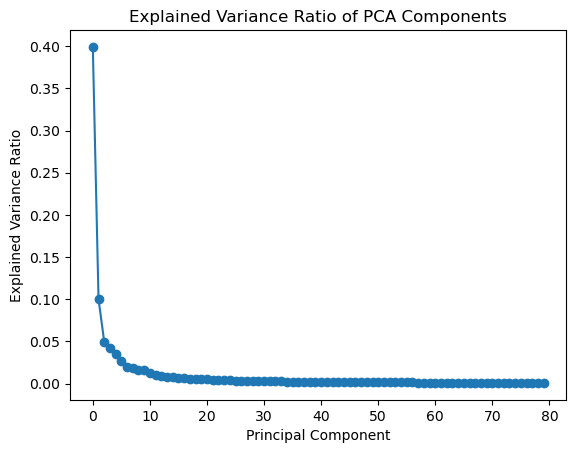

In [17]:
import numpy as np
import os
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def load_feret_data(data_path):
    """load feret"""
    X = []
    y = []
    # Traverse each category directory
    for class_dir in os.listdir(data_path):
        if not class_dir.startswith('class_'):
            continue
        # Parsing category labels
        class_label = int(class_dir.split('_')[1])
        class_dir_path = os.path.join(data_path, class_dir)
        
        # Read all images in the class
        for img_file in os.listdir(class_dir_path):
            img_path = os.path.join(class_dir_path, img_file)
            # Read grayscale image and normalize it
            img = Image.open(img_path).convert('L')
            img_array = np.array(img, dtype=np.float32) / 255.0
            X.append(img_array.flatten())
            y.append(class_label)
    
    # Shuffle the data
    X, y = shuffle(np.array(X), np.array(y), random_state=42)
    return X, y

# load data
data_root = './data/FERET_4096'
X_train, y_train = load_feret_data(os.path.join(data_root, 'train'))
X_test, y_test = load_feret_data(os.path.join(data_root, 'test'))

# PCA
n_components = 80
pca = PCA(n_components=n_components, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# plot
plt.plot(pca.explained_variance_ratio_, 'o-')
plt.title('Explained Variance Ratio of PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [18]:
# Train LLDA_GMM
d = 40
cluster_cnt = 2
def model_perform(d, cluster_cnt,alpha=0.1):
        
    llda_gmm = LLDA_GMM(n_clusters=cluster_cnt, d_components=d,alpha=alpha, max_iter=100)
    llda_gmm.fit(X_train_pca, y_train)

    # Train LLDA_KMeans
    llda_kmeans = LLDA_KMeans(n_clusters=cluster_cnt, d_components=d, max_iter=100)
    llda_kmeans.fit(X_train_pca, y_train)

    # Train LDA
    lda = LDA(n_components=d)
    lda.fit(X_train_pca, y_train)

    # Train KernelLDA (GDA)
    kernel_lda = KernelLDA(kernel='rbf', gamma=1e-5, d_components=d)
    kernel_lda.fit(X_train_pca, y_train)

    # Testing
    import numpy as np
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.decomposition import PCA


    # For the test set, each person picks out a face photo to put into KNN training, and the remaining photos are used as the KNN test set
    unique_subjects = np.unique(y_test)
    X_knn_train = []
    y_knn_train = []
    X_knn_test = []
    y_knn_test = []

    for subject in unique_subjects:
        indices = np.where(y_test == subject)[0]
        # Select a sample as a training set
        train_index = indices[0]
        X_knn_train.append(X_test_pca[train_index])
        y_knn_train.append(y_test[train_index])
        # remaining samples are used as the test set
        test_indices = indices[1:]
        X_knn_test.extend(X_test_pca[test_indices])
        y_knn_test.extend(y_test[test_indices])

    X_knn_train = np.array(X_knn_train)
    y_knn_train = np.array(y_knn_train)
    X_knn_test = np.array(X_knn_test)
    y_knn_test = np.array(y_knn_test)


    X_knn_train_LLDA_Kmeans = llda_kmeans.transform(X_knn_train)
    X_knn_test_LLDA_Kmeans = llda_kmeans.transform(X_knn_test)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_knn_train_LLDA_Kmeans, y_knn_train)

    y_pred = knn.predict(X_knn_test_LLDA_Kmeans)

    accuracy = np.mean(y_pred == y_knn_test)
    print(f"LLDA_Kmeans: {accuracy * 100:.2f}%")


    X_knn_train_LDA = lda.transform(X_knn_train)
    X_knn_test_LDA = lda.transform(X_knn_test)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_knn_train_LDA, y_knn_train)

    y_pred = knn.predict(X_knn_test_LDA)

    accuracy = np.mean(y_pred == y_knn_test)
    print(f"LDA: {accuracy * 100:.2f}%")


    X_knn_train_LDA = llda_gmm.transform(X_knn_train)
    X_knn_test_LDA = llda_gmm.transform(X_knn_test)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_knn_train_LDA, y_knn_train)
    y_pred = knn.predict(X_knn_test_LDA)

    accuracy = np.mean(y_pred == y_knn_test)
    print(f"LLDA_GMM: {accuracy * 100:.2f}%")

    X_knn_train_KernelLDA = kernel_lda.transform(X_knn_train)
    X_knn_test_KernelLDA = kernel_lda.transform(X_knn_test)

    # Train KNN
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_knn_train_KernelLDA, y_knn_train)

    y_pred = knn.predict(X_knn_test_KernelLDA)

    accuracy = np.mean(y_pred == y_knn_test)
    print(f"KernelLDA: {accuracy * 100:.2f}%")

model_perform(d, cluster_cnt,alpha=0.1)

d:\Python\Anaconda\Anaconda3\envs\main_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
d:\Python\Anaconda\Anaconda3\envs\main_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


LLDA_Kmeans: 21.39%
LDA: 80.00%
LLDA_GMM: 44.72%
KernelLDA: 81.67%


In [19]:
# k=3
model_perform(d=40, cluster_cnt=3)

d:\Python\Anaconda\Anaconda3\envs\main_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
d:\Python\Anaconda\Anaconda3\envs\main_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


LLDA_Kmeans: 13.06%
LDA: 80.00%
LLDA_GMM: 39.17%
KernelLDA: 81.67%


In [20]:
# k=5
model_perform(d=40, cluster_cnt=5)

d:\Python\Anaconda\Anaconda3\envs\main_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
d:\Python\Anaconda\Anaconda3\envs\main_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


LLDA_Kmeans: 6.94%
LDA: 80.00%
LLDA_GMM: 37.50%
KernelLDA: 81.67%


In [ ]:
# for drawing
# remark: this code will take a long time to run
llda_gmm_accuracies = []
llda_kmeans_accuracies = []
lda_accuracies = []
kernel_lda_accuracies = []

for d in range(1, 80):

    # # Reduce dimensionality to 80 eigenfeatures
    # n_components = 80
    # pca = PCA(n_components=n_components, whiten=True)
    # X_train_pca = pca.fit_transform(X_train)
    # X_test_pca = pca.transform(X_test)

    # Train LLDA_GMM
    llda_gmm = LLDA_GMM(n_clusters=4, d_components=d, max_iter=100)
    llda_gmm.fit(X_train_pca, y_train)

    # Train LLDA_KMeans
    llda_kmeans = LLDA_KMeans(n_clusters=4, d_components=d, max_iter=100)
    llda_kmeans.fit(X_train_pca, y_train)

    # Train LDA
    lda = LDA(n_components=d)
    lda.fit(X_train_pca, y_train)

    # Train KernelLDA (GDA)
    kernel_lda = KernelLDA(kernel='rbf', gamma=1e-5, d_components=d)
    kernel_lda.fit(X_train_pca, y_train)

    unique_subjects = np.unique(y_test)
    X_knn_train = []
    y_knn_train = []
    X_knn_test = []
    y_knn_test = []

    for subject in unique_subjects:
        indices = np.where(y_test == subject)[0]
        # Select a sample as a training set
        train_index = indices[0]
        X_knn_train.append(X_test_pca[train_index])
        y_knn_train.append(y_test[train_index])
        # remaining samples are used as the test set
        test_indices = indices[1:]
        X_knn_test.extend(X_test_pca[test_indices])
        y_knn_test.extend(y_test[test_indices])

    X_knn_train = np.array(X_knn_train)
    y_knn_train = np.array(y_knn_train)
    X_knn_test = np.array(X_knn_test)
    y_knn_test = np.array(y_knn_test)

    X_knn_train_LLDA_Kmeans = llda_kmeans.transform(X_knn_train)
    X_knn_test_LLDA_Kmeans = llda_kmeans.transform(X_knn_test)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_knn_train_LLDA_Kmeans, y_knn_train)

    y_pred = knn.predict(X_knn_test_LLDA_Kmeans)

    accuracy = np.mean(y_pred == y_knn_test)
    llda_kmeans_accuracies.append(accuracy)

    X_knn_train_LDA = lda.transform(X_knn_train)
    X_knn_test_LDA = lda.transform(X_knn_test)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_knn_train_LDA, y_knn_train)

    y_pred = knn.predict(X_knn_test_LDA)

    accuracy = np.mean(y_pred == y_knn_test)
    lda_accuracies.append(accuracy)

    X_knn_train_LLDA_GMM = llda_gmm.transform(X_knn_train)
    X_knn_test_LLDA_GMM = llda_gmm.transform(X_knn_test) 

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_knn_train_LLDA_GMM, y_knn_train)

    y_pred = knn.predict(X_knn_test_LLDA_GMM)

    accuracy = np.mean(y_pred == y_knn_test)
    llda_gmm_accuracies.append(accuracy)

    X_knn_train_KernelLDA = kernel_lda.transform(X_knn_train)
    X_knn_test_KernelLDA = kernel_lda.transform(X_knn_test)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_knn_train_KernelLDA, y_knn_train)

    y_pred = knn.predict(X_knn_test_KernelLDA)

    accuracy = np.mean(y_pred == y_knn_test)
    kernel_lda_accuracies.append(accuracy)

# plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 80), llda_gmm_accuracies, label='LLDA_GMM')
plt.plot(range(1, 80), llda_kmeans_accuracies, label='LLDA_KMeans')
plt.plot(range(1, 80), lda_accuracies, label='LDA')
plt.plot(range(1, 80), kernel_lda_accuracies, label='KernelLDA')
plt.xlabel('Dimension')
plt.ylabel('Accuaracy')
plt.title('Accuracy under different projection dimensions')
plt.legend()
plt.grid(True)
plt.show()